In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings

np.random.seed(0)

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster


# Load in Tweets

In [4]:
directory = 'elon2010-2022'
dfs = []
for filename in os.listdir(directory):
    dfs.append(pd.read_csv(f'{directory}/{filename}'))

# concatenate all dataframes together
tweets = pd.concat(dfs).drop_duplicates(subset=['id'])

# only select desirable columns from dataframe
tweets = tweets[['date', 'tweet']]

# convert date column to datetime date
tweets['date'] = pd.to_datetime(tweets['date']).dt.normalize()
tweets.sort_values('date', inplace=True)

tweets = tweets.iloc[1:]
tweets.reset_index(drop=True, inplace=True)
tweets.head()

,date,tweet
0,2011-12-01,Went to Iceland on Sat to ride bumper cars on ...
1,2011-12-01,I made the volume on the Model S http://t.co/...
2,2011-12-03,"Great Voltaire quote, arguably better than Twa..."
3,2011-12-03,That was a total non sequitur btw
4,2011-12-04,Am reading a great biography of Ben Franklin b...


# Clean Tweets

In [5]:
import re
import emoji

cleaned = []
for tweet in tweets['tweet']:    
    # remove user references (@exampleUser)
    clean = re.sub(r"\B@\w+", "", tweet)
    
    # remove urls (https://...)
    clean = re.sub(r'http\S+', "", clean)
    
    # replace emojis with their meanings
    clean = emoji.demojize(clean)
    
    cleaned.append(clean)
    
tweets['tweet'] = cleaned
tweets.head()

,date,tweet
0,2011-12-01,Went to Iceland on Sat to ride bumper cars on ...
1,2011-12-01,I made the volume on the Model S go to 11. ...
2,2011-12-03,"Great Voltaire quote, arguably better than Twa..."
3,2011-12-03,That was a total non sequitur btw
4,2011-12-04,Am reading a great biography of Ben Franklin b...


# Conduct Sentiment Analysis on Tweets

NOTE: the block directly below takes a very long time to run. In order to prevent running this every time, the block that is 2 blocks below this reads the scores from 'scores.csv', which contains the saved scores.

In [6]:
%%script false --no-raise-error
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sentiment = SentimentIntensityAnalyzer()
scores = pd.DataFrame()
for tweet in tweets['tweet']:
    scores = pd.concat([scores, pd.DataFrame.from_dict(sentiment.polarity_scores(tweet), orient='index')], axis=1)

scores = scores.T.reset_index(drop=True)
scores.to_csv('scores.csv')

# attach sentiment scores to their corresponding tweet
tweets = pd.concat([tweets, scores[['neg', 'neu', 'pos', 'compound']]], axis=1)
tweets.head()

In [7]:
scores = pd.read_csv('scores.csv')
tweets = pd.concat([tweets, scores[['neg', 'neu', 'pos', 'compound']]], axis=1)
tweets.head()

,date,tweet,neg,neu,pos,compound
0,2011-12-01,Went to Iceland on Sat to ride bumper cars on ...,0.067,0.608,0.325,0.8588
1,2011-12-01,I made the volume on the Model S go to 11. ...,0.000,1.000,0.000,0.0000
2,2011-12-03,"Great Voltaire quote, arguably better than Twa...",0.186,0.505,0.309,0.5994
3,2011-12-03,That was a total non sequitur btw,0.000,1.000,0.000,0.0000
4,2011-12-04,Am reading a great biography of Ben Franklin b...,0.000,0.592,0.408,0.7346


# Identify Relevant Topics

In [8]:
# Find if Tesla relevant
tesla_words = ['tesla', 'model s', 'model 3', 'model x', 'roadster', 'electric', 'car']
tesla = []
for tweet in tweets['tweet']:
    tesla.append(int(any([word in tweet.lower() for word in tesla_words])))
tweets['tesla'] = tesla
tweets.head()

,date,tweet,neg,neu,pos,compound,tesla
0,2011-12-01,Went to Iceland on Sat to ride bumper cars on ...,0.067,0.608,0.325,0.8588,1
1,2011-12-01,I made the volume on the Model S go to 11. ...,0.000,1.000,0.000,0.0000,1
2,2011-12-03,"Great Voltaire quote, arguably better than Twa...",0.186,0.505,0.309,0.5994,0
3,2011-12-03,That was a total non sequitur btw,0.000,1.000,0.000,0.0000,0
4,2011-12-04,Am reading a great biography of Ben Franklin b...,0.000,0.592,0.408,0.7346,0


In [9]:
# Find if crypto relevant
crypto_words = ['crypto', 'currency', 'bitcoin', 'btc', 'eth', 'ethereum', 'doge', 'coin']
crypto = []
for tweet in tweets['tweet']:
    crypto.append(int(any([word in tweet.lower() for word in crypto_words])))
tweets['crypto'] = crypto
tweets.head()

,date,tweet,neg,neu,pos,compound,tesla,crypto
0,2011-12-01,Went to Iceland on Sat to ride bumper cars on ...,0.067,0.608,0.325,0.8588,1,0
1,2011-12-01,I made the volume on the Model S go to 11. ...,0.000,1.000,0.000,0.0000,1,0
2,2011-12-03,"Great Voltaire quote, arguably better than Twa...",0.186,0.505,0.309,0.5994,0,0
3,2011-12-03,That was a total non sequitur btw,0.000,1.000,0.000,0.0000,0,0
4,2011-12-04,Am reading a great biography of Ben Franklin b...,0.000,0.592,0.408,0.7346,0,0


# Aggregate by Date

In [10]:
counts = tweets.groupby(tweets['date']).count()['tweet']
means = tweets.groupby(tweets['date']).mean()
tweetsgb = means
tweetsgb['count'] = counts
tweetsgb.head()

,neg,neu,pos,compound,tesla,crypto,count
date,,,,,,,
2011-12-01,0.033500,0.804000,0.162500,0.429400,1.000000,0.0,2
2011-12-03,0.093000,0.752500,0.154500,0.299700,0.000000,0.0,2
2011-12-04,0.000000,0.592000,0.408000,0.734600,0.000000,0.0,1
2011-12-21,0.074571,0.718571,0.207000,0.245443,0.000000,0.0,7
2011-12-22,0.000000,0.956667,0.043333,0.133967,0.333333,0.0,3


In [11]:
tweetsgb = tweetsgb.asfreq(freq='1D').fillna(0)
tweetsgb.head()

,neg,neu,pos,compound,tesla,crypto,count
date,,,,,,,
2011-12-01,0.0335,0.8040,0.1625,0.4294,1.0,0.0,2.0
2011-12-02,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0
2011-12-03,0.0930,0.7525,0.1545,0.2997,0.0,0.0,2.0
2011-12-04,0.0000,0.5920,0.4080,0.7346,0.0,0.0,1.0
2011-12-05,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0


# Load in Stock Data

## S&P 500

In [12]:
spy = pd.read_csv('SPY.csv')

# convert date column to datetime date
spy['Date'] = pd.to_datetime(spy['Date'])
spy.set_index('Date', inplace=True)

# fill in missing date values with linear approximation
spy = spy.resample('D').interpolate('linear')
spy.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,112.370003,113.389999,111.510002,113.330002,89.610832,118944600.0
2010-01-05,113.260002,113.680000,112.849998,113.629997,89.848030,111579900.0
2010-01-06,113.519997,113.989998,113.430000,113.709999,89.911316,116074400.0
2010-01-07,113.500000,114.330002,113.180000,114.190002,90.290840,131091100.0
2010-01-08,113.889999,114.620003,113.660004,114.570000,90.591293,126402800.0


In [13]:
spy['daily_change'] = (spy['Close']-spy['Open'])/spy['Open']*100
spy.head()

,Open,High,Low,Close,Adj Close,Volume,daily_change
Date,,,,,,,
2010-01-04,112.370003,113.389999,111.510002,113.330002,89.610832,118944600.0,0.854320
2010-01-05,113.260002,113.680000,112.849998,113.629997,89.848030,111579900.0,0.326678
2010-01-06,113.519997,113.989998,113.430000,113.709999,89.911316,116074400.0,0.167373
2010-01-07,113.500000,114.330002,113.180000,114.190002,90.290840,131091100.0,0.607931
2010-01-08,113.889999,114.620003,113.660004,114.570000,90.591293,126402800.0,0.597068


## Tesla

In [14]:
tsla = pd.read_csv('TSLA.csv')

# convert date column to datetime date
tsla['Date'] = pd.to_datetime(tsla['Date'])
tsla.set_index('Date', inplace=True)

# fill in missing date values with linear approximation
tsla = tsla.resample('D').interpolate('linear')
tsla.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-30,5.158,6.084,4.660,4.7660,4.7660,85935500.0
2010-07-01,5.000,5.184,4.054,4.3920,4.3920,41094000.0
2010-07-02,4.600,4.620,3.742,3.8400,3.8400,25699000.0
2010-07-03,4.450,4.465,3.598,3.6855,3.6855,27857875.0
2010-07-04,4.300,4.310,3.454,3.5310,3.5310,30016750.0


In [15]:
tsla['daily_change'] = (tsla['Close']-tsla['Open'])/tsla['Open']*100
tsla.head()

,Open,High,Low,Close,Adj Close,Volume,daily_change
Date,,,,,,,
2010-06-30,5.158,6.084,4.660,4.7660,4.7660,85935500.0,-7.599845
2010-07-01,5.000,5.184,4.054,4.3920,4.3920,41094000.0,-12.160000
2010-07-02,4.600,4.620,3.742,3.8400,3.8400,25699000.0,-16.521739
2010-07-03,4.450,4.465,3.598,3.6855,3.6855,27857875.0,-17.179775
2010-07-04,4.300,4.310,3.454,3.5310,3.5310,30016750.0,-17.883721


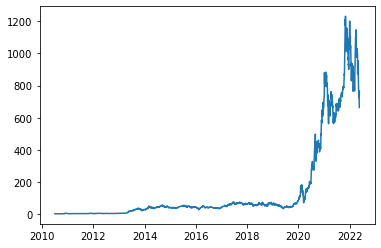

In [16]:
plt.plot(tsla['Adj Close'])

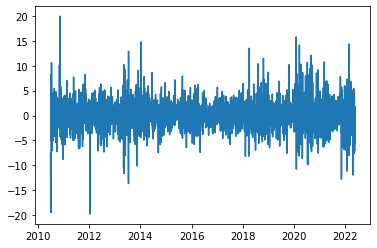

In [17]:
plt.plot(tsla['daily_change'])

## DOGE

In [18]:
doge = pd.read_csv('DOGE-USD.csv')

# convert date column to datetime date
doge['Date'] = pd.to_datetime(doge['Date'])
doge.set_index('Date', inplace=True)

doge.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-09,0.001207,0.001415,0.001181,0.001415,0.001415,6259550
2017-11-10,0.001421,0.001431,0.001125,0.001163,0.001163,4246520
2017-11-11,0.001146,0.001257,0.001141,0.001201,0.001201,2231080
2017-11-12,0.001189,0.001210,0.001002,0.001038,0.001038,3288960
2017-11-13,0.001046,0.001212,0.001019,0.001211,0.001211,2481270


In [19]:
doge['daily_change'] = (doge['Close']-doge['Open'])/doge['Open']*100
doge.head()

,Open,High,Low,Close,Adj Close,Volume,daily_change
Date,,,,,,,
2017-11-09,0.001207,0.001415,0.001181,0.001415,0.001415,6259550,17.232809
2017-11-10,0.001421,0.001431,0.001125,0.001163,0.001163,4246520,-18.156228
2017-11-11,0.001146,0.001257,0.001141,0.001201,0.001201,2231080,4.799302
2017-11-12,0.001189,0.001210,0.001002,0.001038,0.001038,3288960,-12.699748
2017-11-13,0.001046,0.001212,0.001019,0.001211,0.001211,2481270,15.774379


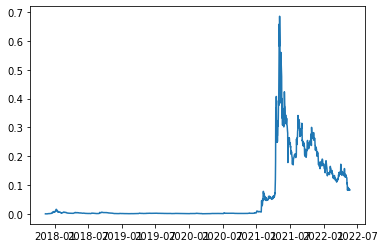

In [20]:
plt.plot(doge['Adj Close'])

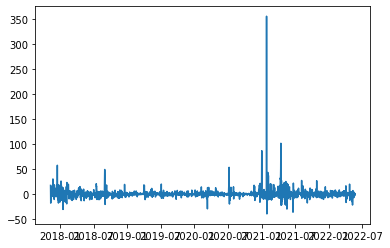

In [21]:
plt.plot(doge['daily_change'])

# Combine Stock Data with Tweet Data

In [22]:
tspy = tweetsgb.merge(spy, left_on='date', right_index=True)
tspy.head()

,neg,neu,pos,compound,tesla,crypto,count,Open,High,Low,Close,Adj Close,Volume,daily_change
date,,,,,,,,,,,,,,
2011-12-01,0.0335,0.8040,0.1625,0.4294,1.0,0.0,2.0,124.849998,125.639999,124.430000,124.970001,102.219971,1.769548e+08,0.096118
2011-12-02,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,126.120003,126.500000,124.779999,124.860001,102.130005,2.211097e+08,-0.999050
2011-12-03,0.0930,0.7525,0.1545,0.2997,0.0,0.0,2.0,126.360001,126.726667,125.000000,125.313334,102.500814,2.224944e+08,-0.828321
2011-12-04,0.0000,0.5920,0.4080,0.7346,0.0,0.0,1.0,126.599998,126.953333,125.220001,125.766668,102.871623,2.238792e+08,-0.658239
2011-12-05,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,126.839996,127.180000,125.440002,126.220001,103.242432,2.252639e+08,-0.488801


In [23]:
ttsla = tweetsgb.merge(tsla, left_on='date', right_index=True)
ttsla.head()

,neg,neu,pos,compound,tesla,crypto,count,Open,High,Low,Close,Adj Close,Volume,daily_change
date,,,,,,,,,,,,,,
2011-12-01,0.0335,0.8040,0.1625,0.4294,1.0,0.0,2.0,6.514000,6.798000,6.396000,6.520000,6.520000,5151000.0,0.092109
2011-12-02,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,6.566000,6.738000,6.480000,6.660000,6.660000,4014000.0,1.431617
2011-12-03,0.0930,0.7525,0.1545,0.2997,0.0,0.0,2.0,6.612667,6.825333,6.548667,6.734667,6.734667,4609500.0,1.844944
2011-12-04,0.0000,0.5920,0.4080,0.7346,0.0,0.0,1.0,6.659333,6.912667,6.617333,6.809333,6.809333,5205000.0,2.252478
2011-12-05,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,6.706000,7.000000,6.686000,6.884000,6.884000,5800500.0,2.654339


In [24]:
tdoge = tweetsgb.merge(doge, left_on='date', right_index=True)
tdoge.head()

,neg,neu,pos,compound,tesla,crypto,count,Open,High,Low,Close,Adj Close,Volume,daily_change
date,,,,,,,,,,,,,,
2017-11-09,0.1290,0.787,0.0835,-0.11315,0.0,0.0,2.0,0.001207,0.001415,0.001181,0.001415,0.001415,6259550,17.232809
2017-11-10,0.0000,0.303,0.6970,0.31820,0.0,0.0,1.0,0.001421,0.001431,0.001125,0.001163,0.001163,4246520,-18.156228
2017-11-11,0.0000,0.000,0.0000,0.00000,0.0,0.0,0.0,0.001146,0.001257,0.001141,0.001201,0.001201,2231080,4.799302
2017-11-12,0.0315,0.931,0.0380,0.06300,0.5,0.0,2.0,0.001189,0.001210,0.001002,0.001038,0.001038,3288960,-12.699748
2017-11-13,0.0000,0.873,0.1270,0.62490,0.0,0.0,1.0,0.001046,0.001212,0.001019,0.001211,0.001211,2481270,15.774379


# Analysis

## S&P 500

In [25]:
X = tspy[['neg', 'neu', 'pos', 'tesla', 'crypto', 'count']]
y = tspy[['daily_change']]
steps = int(len(X) * 0.1)

In [26]:
X_train, X_test, y_train, y_test = X[:-steps], X[-steps:], y[:-steps], y[-steps:]
y_train = y_train.squeeze()
y_test = y_test.squeeze()
y_test_directions = np.array([1 if val > 0 else -1 for val in y_test])

### Lasso Regression

In [27]:
lags = [1, 2, 3, 4, 5]
alphas = [0, 0.0001, 0.001, 0.01, 0.1, 1, 10]

accuracies = []

with warnings.catch_warnings(record=True):
    for lag in lags:
        for alpha in alphas:
            row = {
                'lag': lag,
                'alpha': alpha,
            }
            forecaster = ForecasterAutoreg(
                regressor = make_pipeline(StandardScaler(), Lasso(alpha=alpha, random_state=123)),
                lags = lag
            )
            forecaster.fit(y=y_train, exog=X_train)
            predictions = forecaster.predict(steps=steps, exog=X_test)
            predictions.index = y_test.index
            directions = np.array([1 if prediction > 0 else -1 for prediction in predictions])
            row['accuracy'] = np.count_nonzero(directions == y_test_directions)/len(directions)
            accuracies.append(row)
        
results = pd.DataFrame(accuracies)
results

,lag,alpha,accuracy
0,1,0.0000,0.524064
1,1,0.0001,0.521390
2,1,0.0010,0.521390
3,1,0.0100,0.537433
4,1,0.1000,0.537433
5,1,1.0000,0.537433
6,1,10.0000,0.537433
7,2,0.0000,0.521390
8,2,0.0001,0.524064
9,2,0.0010,0.524064


In [28]:
results.iloc[results['accuracy'].idxmax()]

lag         3.000000
alpha       0.010000
accuracy    0.540107
Name: 17, dtype: float64

### Ridge Regressor

In [29]:
lags = [1, 2, 3, 4, 5]
alphas = [0, 0.0001, 0.001, 0.01, 0.1, 1, 10]

accuracies = []

with warnings.catch_warnings(record=True):
    for lag in lags:
        for alpha in alphas:
            row = {
                'lag': lag,
                'alpha': alpha,
            }
            forecaster = ForecasterAutoreg(
                regressor = make_pipeline(StandardScaler(), Ridge(alpha=alpha, random_state=123)),
                lags = lag
            )
            forecaster.fit(y=y_train, exog=X_train)
            predictions = forecaster.predict(steps=steps, exog=X_test)
            predictions.index = y_test.index
            directions = np.array([1 if prediction > 0 else -1 for prediction in predictions])
            row['accuracy'] = np.count_nonzero(directions == y_test_directions)/len(directions)
            accuracies.append(row)
        
results = pd.DataFrame(accuracies)
results

,lag,alpha,accuracy
0,1,0.0000,0.524064
1,1,0.0001,0.524064
2,1,0.0010,0.524064
3,1,0.0100,0.524064
4,1,0.1000,0.524064
5,1,1.0000,0.521390
6,1,10.0000,0.521390
7,2,0.0000,0.521390
8,2,0.0001,0.521390
9,2,0.0010,0.521390


In [30]:
results.iloc[results['accuracy'].idxmax()]

lag         1.000000
alpha       0.000000
accuracy    0.524064
Name: 0, dtype: float64

### Bagging

In [31]:
forecaster = ForecasterAutoreg(
    regressor = RandomForestRegressor(random_state=123),
    lags = 1
)
forecaster.fit(y=y_train, exog=X_train)
forecaster.get_feature_importance()
predictions = forecaster.predict(steps=steps, exog=X_test)
predictions.index = y_test.index
directions = np.array([1 if prediction > 0 else -1 for prediction in predictions])
np.count_nonzero(directions == y_test_directions)/len(directions)

/usr/local/anaconda3/envs/ada_hw6/lib/python3.8/site-packages/skforecast/utils/utils.py:246: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/usr/local/anaconda3/envs/ada_hw6/lib/python3.8/site-packages/skforecast/utils/utils.py:358: UserWarning: `exog` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/usr/local/anaconda3/envs/ada_hw6/lib/python3.8/site-packages/skforecast/utils/utils.py:246: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


,feature,importance
0,lag_1,0.571245
1,neg,0.070160
2,neu,0.112229
3,pos,0.106340
4,tesla,0.051201
5,crypto,0.018500
6,count,0.070325


/usr/local/anaconda3/envs/ada_hw6/lib/python3.8/site-packages/skforecast/utils/utils.py:358: UserWarning: `exog` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/usr/local/anaconda3/envs/ada_hw6/lib/python3.8/site-packages/skforecast/utils/utils.py:358: UserWarning: `exog` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


0.49732620320855614

<AxesSubplot:xlabel='date'>

<AxesSubplot:xlabel='date'>

<AxesSubplot:xlabel='date'>

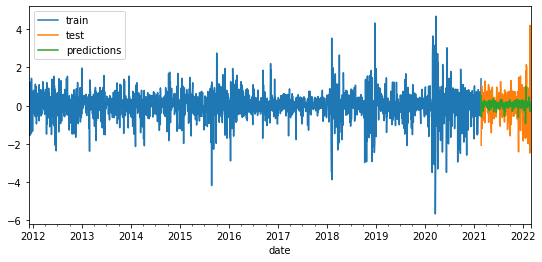

In [32]:
fig, ax=plt.subplots(figsize=(9, 4))
y_train.plot(ax=ax, label='train')
y_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()

In [33]:
lags = [1, 2, 3, 4, 5]
estimators = [10, 50, 100, 200]
depths = [None, 5, 10]

accuracies = []

with warnings.catch_warnings(record=True):
    for lag in lags:
        for estimator in estimators:
            for depth in depths:
                row = {
                    'lag': lag,
                    'estimator': estimator,
                    'depth': depth
                }
                forecaster = ForecasterAutoreg(
                    regressor = RandomForestRegressor(n_estimators=estimator, max_depth=depth, random_state=123),
                    lags = lag
                )
                forecaster.fit(y=y_train, exog=X_train)
                predictions = forecaster.predict(steps=steps, exog=X_test)
                predictions.index = y_test.index
                directions = np.array([1 if prediction > 0 else -1 for prediction in predictions])
                row['accuracy'] = np.count_nonzero(directions == y_test_directions)/len(directions)
                accuracies.append(row)
        
results = pd.DataFrame(accuracies)
results

,lag,estimator,depth,accuracy
0,1,10,NaN,0.545455
1,1,10,5.0,0.524064
2,1,10,10.0,0.502674
3,1,50,NaN,0.508021
4,1,50,5.0,0.534759
5,1,50,10.0,0.491979
6,1,100,NaN,0.497326
7,1,100,5.0,0.537433
8,1,100,10.0,0.524064
9,1,200,NaN,0.451872


In [34]:
results.iloc[results['accuracy'].idxmax()]

lag            2.000000
estimator    100.000000
depth               NaN
accuracy       0.574866
Name: 18, dtype: float64

### Boosting

In [35]:
lags = [1, 2, 3, 4, 5]
estimators = [10, 50, 100, 200]
rates = [0.0001, 0.001, 0.01, 0.1]

accuracies = []

with warnings.catch_warnings(record=True):
    for lag in lags:
        for estimator in estimators:
            for rate in rates:
                row = {
                    'lag': lag,
                    'estimator': estimator,
                    'rate': rate
                }
                forecaster = ForecasterAutoreg(
                    regressor = GradientBoostingRegressor(n_estimators=estimator, learning_rate=rate, random_state=123),
                    lags = lag
                )
                forecaster.fit(y=y_train, exog=X_train)
                predictions = forecaster.predict(steps=steps, exog=X_test)
                predictions.index = y_test.index
                directions = np.array([1 if prediction > 0 else -1 for prediction in predictions])
                row['accuracy'] = np.count_nonzero(directions == y_test_directions)/len(directions)
                accuracies.append(row)
        
results = pd.DataFrame(accuracies)
results

,lag,estimator,rate,accuracy
0,1,10,0.0001,0.537433
1,1,10,0.0010,0.537433
2,1,10,0.0100,0.537433
3,1,10,0.1000,0.540107
4,1,50,0.0001,0.537433
...,...,...,...,...
75,5,100,0.1000,0.465241
76,5,200,0.0001,0.537433
77,5,200,0.0010,0.537433
78,5,200,0.0100,0.537433


In [36]:
results.iloc[results['accuracy'].idxmax()]

lag           1.000000
estimator    10.000000
rate          0.100000
accuracy      0.540107
Name: 3, dtype: float64

### Neural Network

In [37]:
lags = [1, 2, 3]
hidden_layers = [(100, 100, 100), (120, 100, 80, 60), (100, 100, 100, 100, 100)]
activations = ['relu', 'logistic', 'identity']
alphas = [0.0001, 0.001, 0.01, 0.1]

accuracies = []

with warnings.catch_warnings(record=True):
    for lag in lags:
        for hidden_layer in hidden_layers:
            for activation in activations:
                for alpha in alphas:
                    row = {
                        'lag': lag,
                        'hidden_layer': hidden_layer,
                        'activation': activation,
                        'alpha': alpha
                    }
                    forecaster = ForecasterAutoreg(
                        regressor = MLPRegressor(hidden_layer_sizes=hidden_layer, activation=activation, alpha=alpha, solver='adam', random_state=123),
                        lags = lag
                    )
                    forecaster.fit(y=y_train, exog=X_train)
                    predictions = forecaster.predict(steps=steps, exog=X_test)
                    predictions.index = y_test.index
                    directions = np.array([1 if prediction > 0 else -1 for prediction in predictions])
                    row['accuracy'] = np.count_nonzero(directions == y_test_directions)/len(directions)
                    accuracies.append(row)
        
results = pd.DataFrame(accuracies)
results

,lag,hidden_layer,activation,alpha,accuracy
0,1,"(100, 100, 100)",relu,0.0001,0.542781
1,1,"(100, 100, 100)",relu,0.0010,0.569519
2,1,"(100, 100, 100)",relu,0.0100,0.465241
3,1,"(100, 100, 100)",relu,0.1000,0.540107
4,1,"(100, 100, 100)",logistic,0.0001,0.524064
...,...,...,...,...,...
103,3,"(100, 100, 100, 100, 100)",logistic,0.1000,0.537433
104,3,"(100, 100, 100, 100, 100)",identity,0.0001,0.537433
105,3,"(100, 100, 100, 100, 100)",identity,0.0010,0.537433
106,3,"(100, 100, 100, 100, 100)",identity,0.0100,0.537433


In [38]:
results.iloc[results['accuracy'].idxmax()]

lag                           1
hidden_layer    (100, 100, 100)
activation                 relu
alpha                     0.001
accuracy               0.569519
Name: 1, dtype: object

# Tesla

In [39]:
X = ttsla[['neg', 'neu', 'pos', 'tesla', 'crypto', 'count']]
y = ttsla[['daily_change']]
steps = int(len(X) * 0.1)

In [40]:
X_train, X_test, y_train, y_test = X[:-steps], X[-steps:], y[:-steps], y[-steps:]
y_train = y_train.squeeze()
y_test = y_test.squeeze()
y_test_directions = np.array([1 if val > 0 else -1 for val in y_test])

### Lasso Regression

In [41]:
lags = [1, 2, 3, 4, 5]
alphas = [0, 0.0001, 0.001, 0.01, 0.1, 1, 10]

accuracies = []

with warnings.catch_warnings(record=True):
    for lag in lags:
        for alpha in alphas:
            row = {
                'lag': lag,
                'alpha': alpha,
            }
            forecaster = ForecasterAutoreg(
                regressor = make_pipeline(StandardScaler(), Lasso(alpha=alpha, random_state=123)),
                lags = lag
            )
            forecaster.fit(y=y_train, exog=X_train)
            predictions = forecaster.predict(steps=steps, exog=X_test)
            predictions.index = y_test.index
            directions = np.array([1 if prediction > 0 else -1 for prediction in predictions])
            row['accuracy'] = np.count_nonzero(directions == y_test_directions)/len(directions)
            accuracies.append(row)
        
results = pd.DataFrame(accuracies)
results

,lag,alpha,accuracy
0,1,0.0000,0.502674
1,1,0.0001,0.502674
2,1,0.0010,0.502674
3,1,0.0100,0.516043
4,1,0.1000,0.521390
5,1,1.0000,0.521390
6,1,10.0000,0.521390
7,2,0.0000,0.505348
8,2,0.0001,0.505348
9,2,0.0010,0.505348


In [42]:
results.iloc[results['accuracy'].idxmax()]

lag         1.00000
alpha       0.10000
accuracy    0.52139
Name: 4, dtype: float64

### Ridge Regressor

In [43]:
lags = [1, 2, 3, 4, 5]
alphas = [0, 0.0001, 0.001, 0.01, 0.1, 1, 10]

accuracies = []

with warnings.catch_warnings(record=True):
    for lag in lags:
        for alpha in alphas:
            row = {
                'lag': lag,
                'alpha': alpha,
            }
            forecaster = ForecasterAutoreg(
                regressor = make_pipeline(StandardScaler(), Ridge(alpha=alpha, random_state=123)),
                lags = lag
            )
            forecaster.fit(y=y_train, exog=X_train)
            predictions = forecaster.predict(steps=steps, exog=X_test)
            predictions.index = y_test.index
            directions = np.array([1 if prediction > 0 else -1 for prediction in predictions])
            row['accuracy'] = np.count_nonzero(directions == y_test_directions)/len(directions)
            accuracies.append(row)
        
results = pd.DataFrame(accuracies)
results

,lag,alpha,accuracy
0,1,0.0000,0.502674
1,1,0.0001,0.502674
2,1,0.0010,0.502674
3,1,0.0100,0.502674
4,1,0.1000,0.502674
5,1,1.0000,0.502674
6,1,10.0000,0.502674
7,2,0.0000,0.505348
8,2,0.0001,0.505348
9,2,0.0010,0.505348


In [44]:
results.iloc[results['accuracy'].idxmax()]

lag         2.000000
alpha       0.000000
accuracy    0.505348
Name: 7, dtype: float64

### Bagging

In [45]:
forecaster = ForecasterAutoreg(
    regressor = RandomForestRegressor(random_state=123),
    lags = 1
)
forecaster.fit(y=y_train, exog=X_train)
forecaster.get_feature_importance()
predictions = forecaster.predict(steps=steps, exog=X_test)
predictions.index = y_test.index
directions = np.array([1 if prediction > 0 else -1 for prediction in predictions])
np.count_nonzero(directions == y_test_directions)/len(directions)

/usr/local/anaconda3/envs/ada_hw6/lib/python3.8/site-packages/skforecast/utils/utils.py:246: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/usr/local/anaconda3/envs/ada_hw6/lib/python3.8/site-packages/skforecast/utils/utils.py:358: UserWarning: `exog` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/usr/local/anaconda3/envs/ada_hw6/lib/python3.8/site-packages/skforecast/utils/utils.py:246: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


,feature,importance
0,lag_1,0.594223
1,neg,0.072806
2,neu,0.099399
3,pos,0.094119
4,tesla,0.049445
5,crypto,0.017470
6,count,0.072539


/usr/local/anaconda3/envs/ada_hw6/lib/python3.8/site-packages/skforecast/utils/utils.py:358: UserWarning: `exog` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/usr/local/anaconda3/envs/ada_hw6/lib/python3.8/site-packages/skforecast/utils/utils.py:358: UserWarning: `exog` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


0.5374331550802139

<AxesSubplot:xlabel='date'>

<AxesSubplot:xlabel='date'>

<AxesSubplot:xlabel='date'>

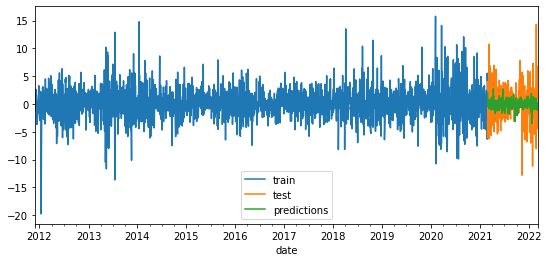

In [46]:
fig, ax=plt.subplots(figsize=(9, 4))
y_train.plot(ax=ax, label='train')
y_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()

<AxesSubplot:xlabel='date'>

<AxesSubplot:xlabel='date'>

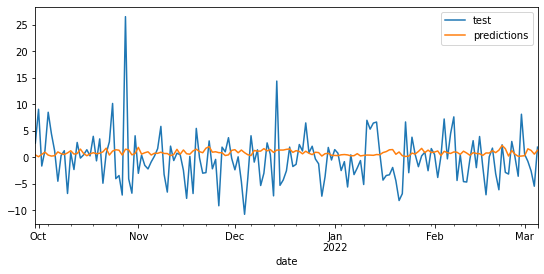

In [70]:
fig, ax=plt.subplots(figsize=(9, 4))
y_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()

In [47]:
lags = [1, 2, 3, 4, 5]
estimators = [10, 50, 100, 200]
depths = [None, 5, 10]

accuracies = []

with warnings.catch_warnings(record=True):
    for lag in lags:
        for estimator in estimators:
            for depth in depths:
                row = {
                    'lag': lag,
                    'estimator': estimator,
                    'depth': depth
                }
                forecaster = ForecasterAutoreg(
                    regressor = RandomForestRegressor(n_estimators=estimator, max_depth=depth, random_state=123),
                    lags = lag
                )
                forecaster.fit(y=y_train, exog=X_train)
                predictions = forecaster.predict(steps=steps, exog=X_test)
                predictions.index = y_test.index
                directions = np.array([1 if prediction > 0 else -1 for prediction in predictions])
                row['accuracy'] = np.count_nonzero(directions == y_test_directions)/len(directions)
                accuracies.append(row)
        
results = pd.DataFrame(accuracies)
results

,lag,estimator,depth,accuracy
0,1,10,NaN,0.542781
1,1,10,5.0,0.508021
2,1,10,10.0,0.518717
3,1,50,NaN,0.486631
4,1,50,5.0,0.505348
5,1,50,10.0,0.524064
6,1,100,NaN,0.537433
7,1,100,5.0,0.494652
8,1,100,10.0,0.508021
9,1,200,NaN,0.516043


In [48]:
results.iloc[results['accuracy'].idxmax()]

lag            2.000000
estimator    100.000000
depth               NaN
accuracy       0.574866
Name: 18, dtype: float64

### Boosting

In [49]:
lags = [1, 2, 3, 4, 5]
estimators = [10, 50, 100, 200]
rates = [0.0001, 0.001, 0.01, 0.1]

accuracies = []

with warnings.catch_warnings(record=True):
    for lag in lags:
        for estimator in estimators:
            for rate in rates:
                row = {
                    'lag': lag,
                    'estimator': estimator,
                    'rate': rate
                }
                forecaster = ForecasterAutoreg(
                    regressor = GradientBoostingRegressor(n_estimators=estimator, learning_rate=rate, random_state=123),
                    lags = lag
                )
                forecaster.fit(y=y_train, exog=X_train)
                predictions = forecaster.predict(steps=steps, exog=X_test)
                predictions.index = y_test.index
                directions = np.array([1 if prediction > 0 else -1 for prediction in predictions])
                row['accuracy'] = np.count_nonzero(directions == y_test_directions)/len(directions)
                accuracies.append(row)
        
results = pd.DataFrame(accuracies)
results

,lag,estimator,rate,accuracy
0,1,10,0.0001,0.521390
1,1,10,0.0010,0.521390
2,1,10,0.0100,0.521390
3,1,10,0.1000,0.526738
4,1,50,0.0001,0.521390
...,...,...,...,...
75,5,100,0.1000,0.516043
76,5,200,0.0001,0.521390
77,5,200,0.0010,0.521390
78,5,200,0.0100,0.521390


In [50]:
results.iloc[results['accuracy'].idxmax()]

lag            2.000000
estimator    200.000000
rate           0.100000
accuracy       0.548128
Name: 31, dtype: float64

### Neural Network

In [51]:
lags = [1, 2, 3]
hidden_layers = [(100, 100, 100), (120, 100, 80, 60), (100, 100, 100, 100, 100)]
activations = ['relu', 'logistic', 'identity']
alphas = [0.0001, 0.001, 0.01, 0.1]

accuracies = []

with warnings.catch_warnings(record=True):
    for lag in lags:
        for hidden_layer in hidden_layers:
            for activation in activations:
                for alpha in alphas:
                    row = {
                        'lag': lag,
                        'hidden_layer': hidden_layer,
                        'activation': activation,
                        'alpha': alpha
                    }
                    forecaster = ForecasterAutoreg(
                        regressor = MLPRegressor(hidden_layer_sizes=hidden_layer, activation=activation, alpha=alpha, solver='adam', random_state=123),
                        lags = lag
                    )
                    forecaster.fit(y=y_train, exog=X_train)
                    predictions = forecaster.predict(steps=steps, exog=X_test)
                    predictions.index = y_test.index
                    directions = np.array([1 if prediction > 0 else -1 for prediction in predictions])
                    row['accuracy'] = np.count_nonzero(directions == y_test_directions)/len(directions)
                    accuracies.append(row)
        
results = pd.DataFrame(accuracies)
results

,lag,hidden_layer,activation,alpha,accuracy
0,1,"(100, 100, 100)",relu,0.0001,0.489305
1,1,"(100, 100, 100)",relu,0.0010,0.516043
2,1,"(100, 100, 100)",relu,0.0100,0.516043
3,1,"(100, 100, 100)",relu,0.1000,0.545455
4,1,"(100, 100, 100)",logistic,0.0001,0.524064
...,...,...,...,...,...
103,3,"(100, 100, 100, 100, 100)",logistic,0.1000,0.521390
104,3,"(100, 100, 100, 100, 100)",identity,0.0001,0.513369
105,3,"(100, 100, 100, 100, 100)",identity,0.0010,0.513369
106,3,"(100, 100, 100, 100, 100)",identity,0.0100,0.513369


In [52]:
results.iloc[results['accuracy'].idxmax()]

lag                           2
hidden_layer    (100, 100, 100)
activation                 relu
alpha                       0.1
accuracy               0.550802
Name: 39, dtype: object

## DOGE

In [53]:
X = tdoge[['neg', 'neu', 'pos', 'tesla', 'crypto', 'count']]
y = tdoge[['daily_change']]
steps = int(len(X) * 0.1)

In [54]:
X_train, X_test, y_train, y_test = X[:-steps], X[-steps:], y[:-steps], y[-steps:]
y_train = y_train.squeeze()
y_test = y_test.squeeze()
y_test_directions = np.array([1 if val > 0 else -1 for val in y_test])

### Lasso Regression

In [55]:
lags = [1, 2, 3, 4, 5]
alphas = [0, 0.0001, 0.001, 0.01, 0.1, 1, 10]

accuracies = []

with warnings.catch_warnings(record=True):
    for lag in lags:
        for alpha in alphas:
            row = {
                'lag': lag,
                'alpha': alpha,
            }
            forecaster = ForecasterAutoreg(
                regressor = make_pipeline(StandardScaler(), Lasso(alpha=alpha, random_state=123)),
                lags = lag
            )
            forecaster.fit(y=y_train, exog=X_train)
            predictions = forecaster.predict(steps=steps, exog=X_test)
            predictions.index = y_test.index
            directions = np.array([1 if prediction > 0 else -1 for prediction in predictions])
            row['accuracy'] = np.count_nonzero(directions == y_test_directions)/len(directions)
            accuracies.append(row)
        
results = pd.DataFrame(accuracies)
results

,lag,alpha,accuracy
0,1,0.0000,0.439490
1,1,0.0001,0.439490
2,1,0.0010,0.433121
3,1,0.0100,0.426752
4,1,0.1000,0.458599
5,1,1.0000,0.484076
6,1,10.0000,0.484076
7,2,0.0000,0.445860
8,2,0.0001,0.445860
9,2,0.0010,0.439490


In [56]:
results.iloc[results['accuracy'].idxmax()]

lag         1.000000
alpha       1.000000
accuracy    0.484076
Name: 5, dtype: float64

### Ridge Regressor

In [57]:
lags = [1, 2, 3, 4, 5]
alphas = [0, 0.0001, 0.001, 0.01, 0.1, 1, 10]

accuracies = []

with warnings.catch_warnings(record=True):
    for lag in lags:
        for alpha in alphas:
            row = {
                'lag': lag,
                'alpha': alpha,
            }
            forecaster = ForecasterAutoreg(
                regressor = make_pipeline(StandardScaler(), Ridge(alpha=alpha, random_state=123)),
                lags = lag
            )
            forecaster.fit(y=y_train, exog=X_train)
            predictions = forecaster.predict(steps=steps, exog=X_test)
            predictions.index = y_test.index
            directions = np.array([1 if prediction > 0 else -1 for prediction in predictions])
            row['accuracy'] = np.count_nonzero(directions == y_test_directions)/len(directions)
            accuracies.append(row)
        
results = pd.DataFrame(accuracies)
results

,lag,alpha,accuracy
0,1,0.0000,0.439490
1,1,0.0001,0.439490
2,1,0.0010,0.439490
3,1,0.0100,0.439490
4,1,0.1000,0.439490
5,1,1.0000,0.439490
6,1,10.0000,0.433121
7,2,0.0000,0.445860
8,2,0.0001,0.445860
9,2,0.0010,0.445860


In [58]:
results.iloc[results['accuracy'].idxmax()]

lag         2.00000
alpha       0.00000
accuracy    0.44586
Name: 7, dtype: float64

### Bagging

In [59]:
forecaster = ForecasterAutoreg(
    regressor = RandomForestRegressor(random_state=123),
    lags = 1
)
forecaster.fit(y=y_train, exog=X_train)
forecaster.get_feature_importance()
predictions = forecaster.predict(steps=steps, exog=X_test)
predictions.index = y_test.index
directions = np.array([1 if prediction > 0 else -1 for prediction in predictions])
np.count_nonzero(directions == y_test_directions)/len(directions)

/usr/local/anaconda3/envs/ada_hw6/lib/python3.8/site-packages/skforecast/utils/utils.py:246: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/usr/local/anaconda3/envs/ada_hw6/lib/python3.8/site-packages/skforecast/utils/utils.py:358: UserWarning: `exog` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/usr/local/anaconda3/envs/ada_hw6/lib/python3.8/site-packages/skforecast/utils/utils.py:246: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


,feature,importance
0,lag_1,0.496007
1,neg,0.057389
2,neu,0.104225
3,pos,0.058976
4,tesla,0.038088
5,crypto,0.016289
6,count,0.229026


/usr/local/anaconda3/envs/ada_hw6/lib/python3.8/site-packages/skforecast/utils/utils.py:358: UserWarning: `exog` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/usr/local/anaconda3/envs/ada_hw6/lib/python3.8/site-packages/skforecast/utils/utils.py:358: UserWarning: `exog` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


0.46496815286624205

<AxesSubplot:xlabel='date'>

<AxesSubplot:xlabel='date'>

<AxesSubplot:xlabel='date'>

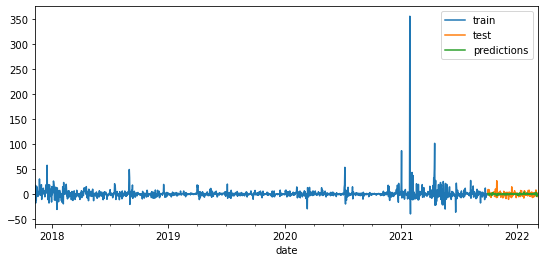

In [60]:
fig, ax=plt.subplots(figsize=(9, 4))
y_train.plot(ax=ax, label='train')
y_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()

In [61]:
lags = [1, 2, 3, 4, 5]
estimators = [10, 50, 100, 200]
depths = [None, 5, 10]

accuracies = []

with warnings.catch_warnings(record=True):
    for lag in lags:
        for estimator in estimators:
            for depth in depths:
                row = {
                    'lag': lag,
                    'estimator': estimator,
                    'depth': depth
                }
                forecaster = ForecasterAutoreg(
                    regressor = RandomForestRegressor(n_estimators=estimator, max_depth=depth, random_state=123),
                    lags = lag
                )
                forecaster.fit(y=y_train, exog=X_train)
                predictions = forecaster.predict(steps=steps, exog=X_test)
                predictions.index = y_test.index
                directions = np.array([1 if prediction > 0 else -1 for prediction in predictions])
                row['accuracy'] = np.count_nonzero(directions == y_test_directions)/len(directions)
                accuracies.append(row)
        
results = pd.DataFrame(accuracies)
results

,lag,estimator,depth,accuracy
0,1,10,NaN,0.484076
1,1,10,5.0,0.477707
2,1,10,10.0,0.414013
3,1,50,NaN,0.496815
4,1,50,5.0,0.401274
5,1,50,10.0,0.420382
6,1,100,NaN,0.464968
7,1,100,5.0,0.407643
8,1,100,10.0,0.433121
9,1,200,NaN,0.433121


In [62]:
results.iloc[results['accuracy'].idxmax()]

lag           4.000000
estimator    10.000000
depth         5.000000
accuracy      0.515924
Name: 37, dtype: float64

### Boosting

In [63]:
lags = [1, 2, 3, 4, 5]
estimators = [10, 50, 100, 200]
rates = [0.0001, 0.001, 0.01, 0.1]

accuracies = []

with warnings.catch_warnings(record=True):
    for lag in lags:
        for estimator in estimators:
            for rate in rates:
                row = {
                    'lag': lag,
                    'estimator': estimator,
                    'rate': rate
                }
                forecaster = ForecasterAutoreg(
                    regressor = GradientBoostingRegressor(n_estimators=estimator, learning_rate=rate, random_state=123),
                    lags = lag
                )
                forecaster.fit(y=y_train, exog=X_train)
                predictions = forecaster.predict(steps=steps, exog=X_test)
                predictions.index = y_test.index
                directions = np.array([1 if prediction > 0 else -1 for prediction in predictions])
                row['accuracy'] = np.count_nonzero(directions == y_test_directions)/len(directions)
                accuracies.append(row)
        
results = pd.DataFrame(accuracies)
results

,lag,estimator,rate,accuracy
0,1,10,0.0001,0.484076
1,1,10,0.0010,0.484076
2,1,10,0.0100,0.484076
3,1,10,0.1000,0.484076
4,1,50,0.0001,0.484076
...,...,...,...,...
75,5,100,0.1000,0.420382
76,5,200,0.0001,0.484076
77,5,200,0.0010,0.484076
78,5,200,0.0100,0.484076


In [64]:
results.iloc[results['accuracy'].idxmax()]

lag           1.000000
estimator    10.000000
rate          0.000100
accuracy      0.484076
Name: 0, dtype: float64

### Neural Network

In [65]:
lags = [1, 2, 3]
hidden_layers = [(100, 100, 100), (120, 100, 80, 60), (100, 100, 100, 100, 100)]
activations = ['relu', 'logistic', 'identity']
alphas = [0.0001, 0.001, 0.01, 0.1]

accuracies = []

with warnings.catch_warnings(record=True):
    for lag in lags:
        for hidden_layer in hidden_layers:
            for activation in activations:
                for alpha in alphas:
                    row = {
                        'lag': lag,
                        'hidden_layer': hidden_layer,
                        'activation': activation,
                        'alpha': alpha
                    }
                    forecaster = ForecasterAutoreg(
                        regressor = MLPRegressor(hidden_layer_sizes=hidden_layer, activation=activation, alpha=alpha, solver='adam', random_state=123),
                        lags = lag
                    )
                    forecaster.fit(y=y_train, exog=X_train)
                    predictions = forecaster.predict(steps=steps, exog=X_test)
                    predictions.index = y_test.index
                    directions = np.array([1 if prediction > 0 else -1 for prediction in predictions])
                    row['accuracy'] = np.count_nonzero(directions == y_test_directions)/len(directions)
                    accuracies.append(row)
        
results = pd.DataFrame(accuracies)
results

,lag,hidden_layer,activation,alpha,accuracy
0,1,"(100, 100, 100)",relu,0.0001,0.382166
1,1,"(100, 100, 100)",relu,0.0010,0.407643
2,1,"(100, 100, 100)",relu,0.0100,0.420382
3,1,"(100, 100, 100)",relu,0.1000,0.407643
4,1,"(100, 100, 100)",logistic,0.0001,0.522293
...,...,...,...,...,...
103,3,"(100, 100, 100, 100, 100)",logistic,0.1000,0.484076
104,3,"(100, 100, 100, 100, 100)",identity,0.0001,0.484076
105,3,"(100, 100, 100, 100, 100)",identity,0.0010,0.484076
106,3,"(100, 100, 100, 100, 100)",identity,0.0100,0.484076


In [66]:
results.iloc[results['accuracy'].idxmax()]

lag                           1
hidden_layer    (100, 100, 100)
activation             logistic
alpha                    0.0001
accuracy               0.522293
Name: 4, dtype: object